In [4]:
import pandas as pd
import logging

# Log fayl manzili
log_path = r"C:\Users\Rasulbek907\Desktop\Project_8\Log\error_analysis.log"

# Log sozlamalari
logging.basicConfig(
    filename=log_path,
    filemode='a',  # Append mode
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

try:
    logging.info("CSV fayl o'qilmoqda:...")
    df = pd.read_csv(r"C:\Users\Rasulbek907\Desktop\Project_8\Data\Feature_Selection\Filtered_Features.csv")
    logging.info(f"Fayl muvaffaqiyatli o'qildi. Satırlar soni: {len(df)} ustunlar soni: {len(df.columns)}")
except Exception as e:
    logging.error(f"CSV faylni o'qishda xatolik: {e}")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322278 entries, 0 to 322277
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            322278 non-null  int64  
 1   index                 322278 non-null  float64
 2   dateCrawled           322278 non-null  float64
 3   name                  322278 non-null  float64
 4   vehicleType           322278 non-null  float64
 5   yearOfRegistration    322278 non-null  float64
 6   model                 322278 non-null  float64
 7   monthOfRegistration   322278 non-null  float64
 8   fuelType              322278 non-null  float64
 9   brand                 322278 non-null  float64
 10  postalCode            322278 non-null  float64
 11  lastSeen              322278 non-null  float64
 12  abtest_control        322278 non-null  float64
 13  gearbox_automatik     322278 non-null  float64
 14  notRepairedDamage_ja  322278 non-null  float64
 15  

c:\Users\Rasulbek907\Desktop\Project_8\mpvenv\Lib\site-packages\shap\explainers\_tree.py:254: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


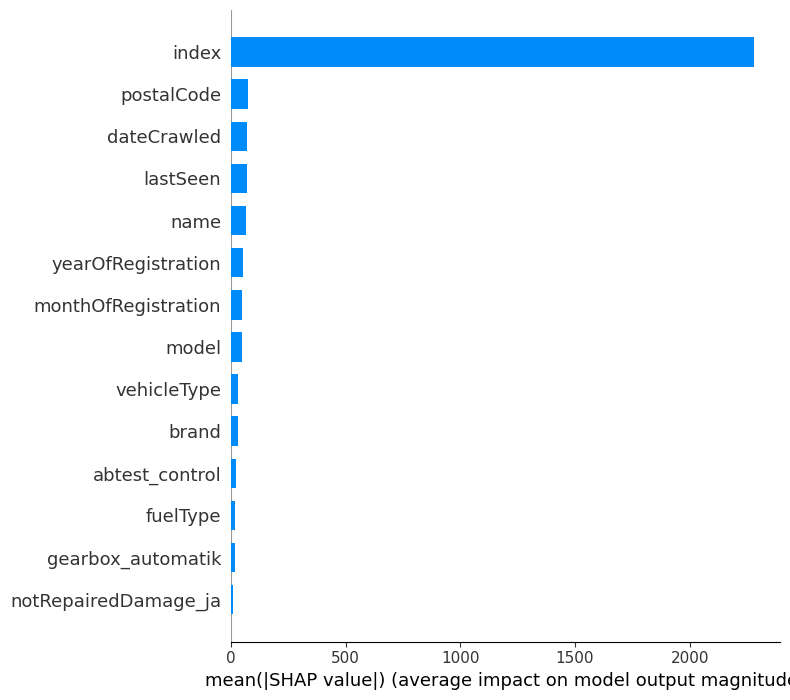

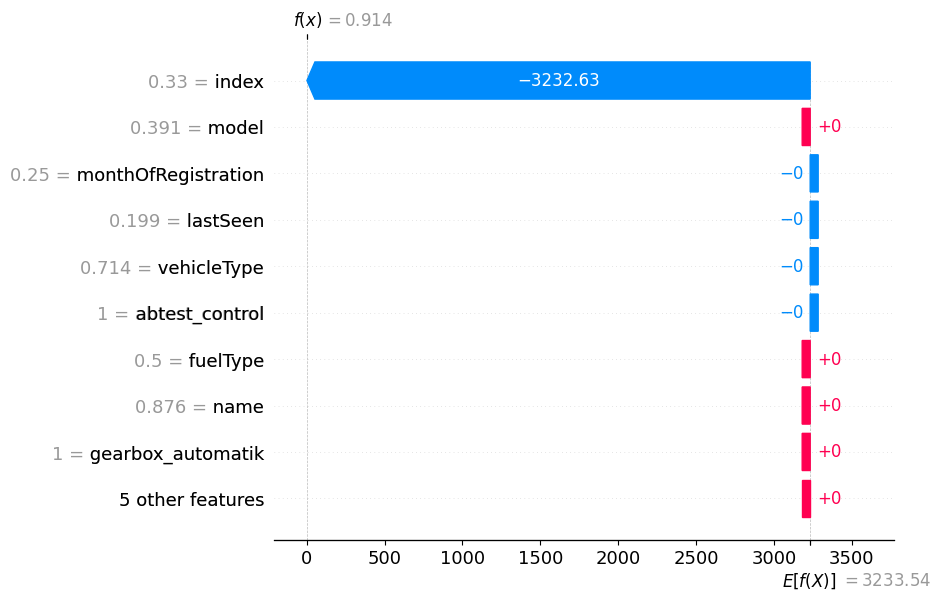

In [6]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# --- Ma'lumotni tayyorlash ---
X = df.drop(columns=['Unnamed: 0', 'kilometer_cont'])
y = df['kilometer_cont']

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# --- Model ---
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# --- SHAP uchun random subset (tezlik uchun) ---
X_sample = X_test.sample(10000, random_state=42)  # 10k sample tezroq hisoblash uchun

# --- SHAP ---
explainer = shap.TreeExplainer(model, model_output='raw', feature_perturbation="interventional")
shap_values = explainer.shap_values(X_sample, approximate=True)  # tezkor hisoblash

# --- Summary plot ---
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# --- Waterfall plot (birinchi sample uchun) ---
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                      base_values=explainer.expected_value, 
                                      data=X_sample.iloc[0]))


# SHAP Natijalar Tahlili

Keltirilgan SHAP grafiklari asosida model va feature’larning ta’siri tahlil qilindi.

---

## 1️⃣ Summary Plot (Bir nechta sample)

- **Grafik ma’nosi:** `mean(|SHAP value|)` asosida barcha feature’larning model chiqishiga ta’sirini ko‘rsatadi.  
- **Eng katta ta’sir ko‘rsatadigan feature:** `index`.  
- Boshqa feature’lar (`postalCode`, `dateCrawled`, `lastSeen`, `name`, `yearOfRegistration`, ...) nisbatan kam ta’sir qilgan.  
- **Xulosa:** `index` feature modelning asosiy qaror qabul qiluvchi faktori bo‘lgan. Agar `index` faqat identifikator bo‘lsa, bu modelga noto‘g‘ri signal yuboradi va overfitting ehtimolini oshiradi.

---

## 2️⃣ Waterfall Plot (Bitta sample)

- **Grafik ma’nosi:** Bitta sample uchun feature’larning model chiqishiga ta’sirini ko‘rsatadi.  
- **Model prognozi:** `f(x) = 0.914`  
- **Index feature ta’siri:** -3232.63 → model chiqishini sezilarli pasaytirgan.  
- Boshqa feature’larning SHAP qiymatlari juda kichik (`0` ga yaqin) → model chiqishiga deyarli ta’sir qilmagan.  

**Xulosa:**  
- Model shu sample bo‘yicha `index` ga haddan tashqari bog‘liq.  
- Boshqa feature’lar (`model`, `monthOfRegistration`, `lastSeen`, `vehicleType`, `fuelType`, `name`, `gearbox_automatik`) amalda model chiqishiga deyarli ta’sir qilmaydi.  
- Bu holat **overfitting** va keraksiz feature ishlatilayotganini ko‘rsatadi.

---

## 3️⃣ Tavsiyalar

1. `index` feature’ni modeldan olib tashlash.  
2. Katta ta’sirga ega bo‘lgan real prediktorlar (`model`, `vehicleType`, `fuelType`, `gearbox_automatik`) ni yaxshilab kodlash va tekshirish.  
3. Keraksiz feature’lar chiqarilgach, model yanada ishonchli va umumiylashgan bo‘ladi.  
